In [1]:
from datetime import datetime
from pytz import timezone

tz = timezone('EST')

print("Kernel is up")
print(datetime.now(tz))

Kernel is up
2019-02-08 12:15:18.550425-05:00


# WGAN-GP with DCGAN layers
Code is mainly based upon the DCGAN implementation in the TensorFlow tutorials

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
#import memory_saving_gradients
# monkey patch tf.gradients to point to our custom version, with automatic checkpoint selection
#tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import librosa
import os
import functools
import subprocess
import time
import numpy as np
import matplotlib.pyplot as plt
#import PIL
#import imageio
#import simpleaudio as sa
import math
import gc
from IPython import display
import time
import scipy.io.wavfile as wavfile
from tensorflow.layers import dense, flatten
from tensorflow.nn import relu, leaky_relu
from tensorflow import tanh
from tensorflow.image import ResizeMethod
#from google.cloud import storage
#import google.auth
#from google.auth import compute_engine

resize_images = functools.partial(tf.image.resize_bilinear, align_corners=True)
conv2d_transpose = functools.partial(tf.layers.conv2d_transpose, padding='same')
conv2d = functools.partial(tf.layers.conv2d, padding='same')
batch_norm = tf.layers.batch_normalization
layer_norm = tf.contrib.layers.layer_norm
pool = functools.partial(tf.nn.pool, window_shape=(2, 2), pooling_type='AVG', padding='SAME', data_format='NHWC')

In [3]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

# Hyperparameters

In [4]:
# Number for large nsynth-train dataset
TOTAL_NUM = 102165
# Number for small nsynth-test dataset
# TOTAL_NUM = 1689
BUFFER_SIZE = 2048
BATCH_SIZE = 64 * 2
PREFETCH_BUFFER_SIZE = 2 * BATCH_SIZE
# EPOCHS = 150
LAMBDA = 10
ALPHA = 0.0002
BETA1 = 0.5
BETA2 = 0.999
CRITIC_UPDATES_PER_GEN_UPDATE = 5
noise_dim = 100
num_steps = 100
num_tpu = 1
num_examples_to_generate = 16
epoch_counter = 0
spec_dim = (128, 504, 3)
dataset_spec_dim = (3, 128, 504)
epoch_proportion_counter = 0.0
model_dir = 'gs://jz-model-checkpoints/gan-tpu-nhwc-opt-test/'
#model_dir = 'gs://jz-model-checkpoints/gan-tpu-lr-01/'
tpu_name = "node4"

# Defining models

In [5]:
def residBlockUpscale(num, x, num_filters, filter_size=5, strides=(2, 2), 
                      num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-upscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = resize_images(x, (x.shape[1]*strides[0], x.shape[2]*strides[1]))
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = resize_images(x, (x.shape[1]*strides[0], x.shape[2]*strides[1]))
        x = conv2d(x, num_filters_intermed, filter_size, 1, use_bias=False)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, num_filters, filter_size, 1, use_bias=False)
        x = x_orig + x
        return x

def residBlockDownscale(num, x, num_filters, filter_size=5, strides=(2, 2), 
                        num_filters_intermed=None, training=True):
    with tf.variable_scope('resid-block-downscale-{}'.format(num)):
        if(num_filters_intermed is None):
            num_filters_intermed = num_filters
        x_orig = pool(x, window_shape=strides)
        x_orig = conv2d(x_orig, num_filters, 1, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters_intermed, filter_size, 1)
        x = layer_norm(x)
        x = relu(x)
        x = conv2d(x, num_filters, filter_size, 1)
        x = pool(x)
        x = x_orig + x
        return x
    
def upsampleConvBatchNorm(num, x, num_filters, filter_size=5, strides=(2, 2), training=True):
    with tf.variable_scope('upsample-conv-batch-norm-{}'.format(num)):
        x = resize_images(x, (x.shape[1]*strides[0], x.shape[2]*strides[1]))
        x = conv2d(x, num_filters, filter_size, 1, use_bias=False)
        x = batch_norm(x, training=training)
        x = relu(x)
        return x

def convLayerNorm(num, x, num_filters, filter_size=5, strides=(2, 2), training=True):
    with tf.variable_scope('conv-layer-norm-{}'.format(num)):
        x = conv2d(x, num_filters, filter_size, strides=strides)
        x = layer_norm(x)
        x = leaky_relu(x)
        return x

def convBatchNorm(num, x, num_filters, filter_size=5, strides=(2, 2), training=True):
    with tf.variable_scope('conv-batch-norm-{}'.format(num)):
        x = conv2d(x, num_filters, filter_size, strides=strides)
        x = batch_norm(x, training=training)
        x = leaky_relu(x)
        return x

In [6]:
def generator(x, batch_size, training=True):
    # Input x is noise vector
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        if(callable(x)):
            x = x()
        # x_orig = tf.transpose(tf.image.resize_bicubic(tf.transpose(x, [0, 2, 3, 1]), 512*256), [0, 3, 1, 2])
        x.set_shape([batch_size, noise_dim])
        x = dense(x, 512*8*32)
        # MAKE SURE SHAPES ARE EQUAL, OR ELSE SIZE -1 WILL CAUSE BATCH SIZE MISMATCH
        x = tf.reshape(x, shape=(batch_size, 8, 32, 512))
        x = upsampleConvBatchNorm(1, x, 512, filter_size=5, training=training)
        x = upsampleConvBatchNorm(2, x, 256, filter_size=5, training=training)
        x = upsampleConvBatchNorm(3, x, 128, filter_size=5, training=training)
        x = upsampleConvBatchNorm(4, x, 128, filter_size=5, training=training)
        x = batch_norm(x, training=training)
        x = relu(x)
        x = conv2d(x, 3, 5, 1)
        x = tanh(x)
        x = x[:, :, 0:spec_dim[1], :]
        x.set_shape([batch_size, 128, 504, 3])
        return x
    
def critic(x, batch_size, training=True):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE):
        x.set_shape([batch_size, spec_dim[0], spec_dim[1], spec_dim[2]])
        x = convLayerNorm(1, x, 128, strides=(1, 1), training=training)
        x = convLayerNorm(2, x, 128, training=training)
        x = convLayerNorm(3, x, 128, training=training)
        x = convLayerNorm(4, x, 256, training=training)
        x = convLayerNorm(5, x, 512, training=training)
        x = tf.reshape(x, shape=(batch_size, -1))
        x = dense(x, 1)
        return x

# Making a TPUEstimator

In [7]:
def record_parser(raw_data):
    read_features = {
            'note': tf.FixedLenFeature([], dtype=tf.int64),
            'note_str': tf.FixedLenFeature([], dtype=tf.string),
            'instrument': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
            'pitch': tf.FixedLenFeature([], dtype=tf.int64),
            'velocity': tf.FixedLenFeature([], dtype=tf.int64),
            'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
            'spectrogram': tf.FixedLenFeature([193536], dtype=tf.float32),
            #'spectrogram': tf.FixedLenFeature([128512], dtype=tf.float32),
            'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
            'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
            'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
    }
    return tf.transpose(tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], dataset_spec_dim), [1, 2, 0])

params = {
    'batch_size': BATCH_SIZE,
}

def input_fn(params):
    with tf.variable_scope('input-pipeline'):
        batch_size = params['batch_size']
        # Reading features of TFRecord file
        files = tf.data.Dataset.list_files('gs://jz-datasets/spec-files/*.tfrecord')
        specs = files.apply(tf.data.experimental.parallel_interleave(tf.data.TFRecordDataset, cycle_length=2))
        specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
        # specs = specs.map(map_func=(lambda raw_data: tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], spec_dim)), num_parallel_calls=-1)
        specs = specs.apply(tf.data.experimental.map_and_batch(
            map_func=lambda x: (record_parser(x), tf.zeros(batch_size)), 
            num_parallel_calls=-1, 
            batch_size=batch_size, 
            drop_remainder=True))
        specs = specs.prefetch(buffer_size=2*batch_size)
        return specs
    
def model_fn(features, labels, mode, params):
    batch_size = params['batch_size']
    global_step = tf.train.get_or_create_global_step()
    critic_step = tf.Variable(0, dtype=tf.float32)
    gen_step = tf.Variable(0, dtype=tf.float32)
    run_critic = tf.ceil(tf.div(tf.cast(tf.mod(global_step, (CRITIC_UPDATES_PER_GEN_UPDATE+1)), tf.float32), float(CRITIC_UPDATES_PER_GEN_UPDATE+1)))
    with tf.variable_scope('runs'):
        real_images = features
        noise = tf.random_normal([batch_size, noise_dim])
        random_vector_for_generation = tf.random_normal([batch_size, noise_dim])
        fake_images = generator(noise, batch_size)
        fake_images_for_prediction = generator(random_vector_for_generation, batch_size, training=False)
        critic_real = critic(real_images, batch_size)
        critic_fake = critic(fake_images, batch_size)
        # keeping the random vector constant for generation (prediction) so
        # it will be easier to see the improvement of the gan.
        
    if mode == tf.estimator.ModeKeys.PREDICT:
        test_images = {
            'fake_images': fake_images_for_prediction,
            'real_images': features,
            'global_step': tf.tile(tf.reshape(global_step, [1, 1]), [batch_size, 1]),
            'critic_step': tf.tile(tf.reshape(critic_step, [1, 1]), [batch_size, 1]),
            'gen_step': tf.tile(tf.reshape(gen_step, [1, 1]), [batch_size, 1])
        }
        return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=test_images)
    
    with tf.variable_scope('costs'):
        gen_cost = -tf.reduce_mean(critic_fake)*(1-run_critic)
        critic_cost_naive = tf.reduce_mean(critic_fake)-tf.reduce_mean(critic_real)

        with tf.variable_scope('gradient-penalty'):
            alpha = tf.random_uniform(shape=[batch_size, spec_dim[0], spec_dim[1], spec_dim[2]], minval=0., maxval=1.)
            differences = fake_images-real_images
            interpolates = real_images+(alpha*differences)
            gradients = tf.gradients(critic(interpolates, batch_size), [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes-1.)**2)
            critic_cost = critic_cost_naive + LAMBDA*gradient_penalty
            critic_cost *= run_critic

        costs = {
            'gen_cost': gen_cost,
            'critic_cost': critic_cost
        }

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=0) # , eval_metric_ops=costs)

    if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope('optimizers'):
            gen_opt = tf.contrib.tpu.CrossShardOptimizer(tf.train.AdamOptimizer(ALPHA, BETA1, BETA2))
            critic_opt = tf.contrib.tpu.CrossShardOptimizer(tf.train.AdamOptimizer(ALPHA, BETA1, BETA2))
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                critic_opt = critic_opt.minimize(critic_cost, global_step=critic_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/critic'))
            with tf.control_dependencies([critic_opt]):
                gen_opt = gen_opt.minimize(gen_cost, global_step=gen_step, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='runs/generator'))
            with tf.control_dependencies([gen_opt]):
                opt = tf.assign_add(global_step, 1)
        return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=critic_cost, train_op=opt)

    return
    #return generator, gen_opt, critic_opt, real_images, test_images, ranEpoch, getEpoch, increment, merged, global_step

In [8]:
def testAudio(specs, prefix):
    for i in range(specs.shape[0]):
        spec = specs[i]
        mag = spec[:, :, 0]
        angles = np.arctan2(spec[:, :, 2], spec[:, :, 1])
        mag = ((mag+1)/2)*48-32
        ft = (np.exp(mag)-1.2664166e-14)*np.exp(1j*angles)
        newaudio = librosa.istft(ft, 127, 254).astype(np.int16)
        #print('Generated audio')
        #print('Interval of audio: [{}, {}]'.format(np.amin(newaudio), np.amax(newaudio)))
        wavfile.write("audio/{}-{}.wav".format(prefix, i+1), 16000, newaudio)

In [9]:
def runOneEpoch(model, epoch_proportion=1):
    global epoch_counter
    start = time.time()
    
    model.train(input_fn, steps=num_steps)
    
    predictions = next(iter(model.predict(input_fn, yield_single_examples=False)))
    display.clear_output(wait=True)
    print(datetime.now(tz))
    global_step, critic_step, gen_step = generate_images(predictions, source='fake')
    generate_images(predictions, source='real')
    print("Finished global step {}, critic step {}, and generator step {}".format(global_step, critic_step, gen_step))
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken: {} sec'.format(time.time()-start))
    gc.collect()

In [10]:
def generate_images(images, source='fake', save=True):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    
    if(source=='fake'):
        disp_images = images['fake_images']
    elif(source=='real'):
        disp_images = images['real_images']
    else:
        raise ValueError
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, :, :, 0] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    if(save):
        plt.savefig('images/image_at_{}_{}.png'.format(images['global_step'][0, 0], source))
    plt.show()
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i, :, :, 1] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    plt.show()
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(disp_images[i,:, :, 2] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')
    plt.show()
    
    return images['global_step'][0, 0], np.round(images['critic_step'][0, 0]), np.round(images['gen_step'][0, 0]) 

# Running the model

In [11]:
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
    tpu=["node4"], 
    zone="us-central1-f", 
    project="jz-cloud-test"
)

#cluster_resolver2 = tf.contrib.cluster_resolver.TPUClusterResolver(
#    tpu=["node2"], 
#    zone="us-central1-f", 
#    project="jz-cloud-test"
#)

#cluster_resolver = tf.contrib.cluster_resolver.UnionClusterResolver(cluster_resolver1, cluster_resolver2)
print(cluster_resolver.__dict__)

tpu_run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver, 
    model_dir=model_dir,
    session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(num_steps, 8)
)  

model = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn, 
    config=tpu_run_config, 
    use_tpu=True, 
    train_batch_size=BATCH_SIZE, 
    predict_batch_size=16,
)

{'_zone': 'us-central1-f', '_coordinator_name': None, '_coordinator_address': None, '_project': 'jz-cloud-test', '_job_name': 'worker', '_credentials': <oauth2client.contrib.gce.AppAssertionCredentials object at 0x7f956282b7f0>, '_tpu': b'node4', '_service': <googleapiclient.discovery.Resource object at 0x7f95627f2438>}
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_protocol': None, '_session_config': allow_soft_placement: true
log_device_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      value: "10.12.4.4:8470"
    }
  }
}
, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_tf_random_seed': None, '_train_distribute': None, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95627f2898>, '_tpu_config': TPUConfig(iterations_per_loop=100, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=2, tpu_job_name=None, initial_infeed_sleep_secs=None, input_partition_dims=None), '_k

In [40]:
# Waits for another program to remove the .lock file before continuing execution
# !rm .lock
# Comment out next line to disable lock
# !touch .lock
i = 0
while True:
    if(os.path.isfile('.lock')):
        break
    try:
        runOneEpoch(model)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print("Caught error")
        i += 1
        if(i >= 1):
            raise

print("Training stopped")

INFO:tensorflow:Querying Tensorflow master (grpc://10.12.4.4:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4710743465753485432)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8293632652088265030)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3908733160018541471)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2402519334499935631)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13853328742478641225)
INFO:tensorflow:*** Available Device: _DeviceAttribu

KeyboardInterrupt: 

In [ ]:
predictions = next(iter(model.predict(input_fn, yield_single_examples=False)))
global_step, critic_step, gen_step = generate_images(predictions, source='fake')
generate_images(predictions, source='real')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://jz-model-checkpoints/gan-tpu-nhwc-opt-test/model.ckpt-121500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 3 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.
INFO:tensorflow:Error recorded from infeed: Step was cancelled by an explicit call to `Session::Close()`.
INFO:tensorflow:prediction_loop marked as finished


Exception ignored in: <generator object TPUEstimator.predict at 0x7f89b9396888>
Traceback (most recent call last):
  File "/home/asianzhang812_gmail_com/.local/lib/python3.5/site-packages/tensorflow/contrib/tpu/python/tpu/tpu_estimator.py", line 2446, in predict
    rendezvous.raise_errors()
  File "/home/asianzhang812_gmail_com/.local/lib/python3.5/site-packages/tensorflow/contrib/tpu/python/tpu/error_handling.py", line 132, in raise_errors
    six.reraise(typ, value, traceback)
  File "/home/asianzhang812_gmail_com/.local/lib/python3.5/site-packages/six.py", line 693, in reraise
    raise value
  File "/home/asianzhang812_gmail_com/.local/lib/python3.5/site-packages/tensorflow/contrib/tpu/python/tpu/error_handling.py", line 101, in catch_errors
    yield
  File "/home/asianzhang812_gmail_com/.local/lib/python3.5/site-packages/tensorflow/contrib/tpu/python/tpu/tpu_estimator.py", line 442, in _run_infeed
    session.run(self._enqueue_ops)
  File "/home/asianzhang812_gmail_com/.local/li

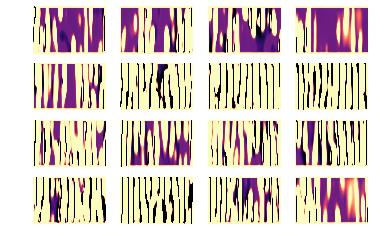

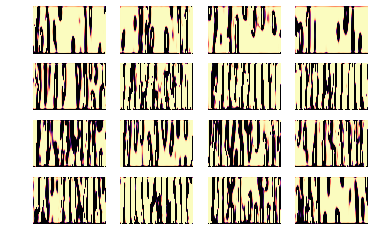

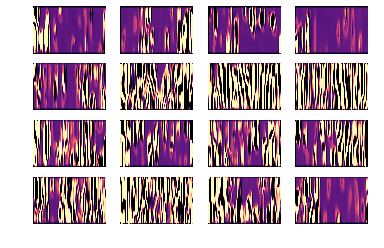

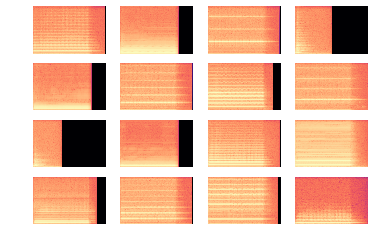

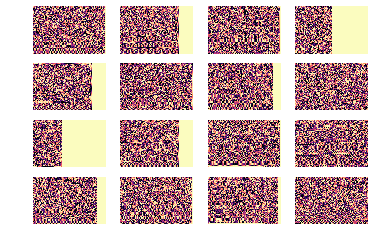

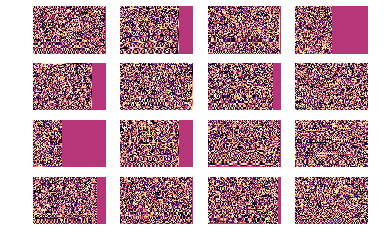

Global step: 121500


In [54]:
predictions = next(iter(model.predict(input_fn, yield_single_examples=False)))
global_step, critic_step, gen_step = generate_images(predictions, source='fake', save=False)
generate_images(predictions, source='real', save=False)
print("Global step: {}".format(global_step))
testAudio(predictions['real_images'], "real")
testAudio(predictions['fake_images'], "fake-{}".format(global_step))
display.display(display.Audio("audio/real-1.wav"), display.Audio("audio/fake-{}-1.wav".format(global_step)))

In [ ]:
while(kernel is dead):
    plant_a_new_seed()